In [1]:
import pandas as pd
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path

data_path = '/home/ubuntu/landscape-aesthetics/data/external/scenicornot/scenicornot.metadata.csv'
image_folder = Path('/home/ubuntu/landscape-aesthetics/data/external/scenicornot') 

# Check if the data path exists
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Data file not found at {data_path}")

#read dataset
data = pd.read_csv(data_path)

# Check if the root directory exists
root_dir = '/home/ubuntu/landscape-aesthetics/data/external/scenicornot/'
if not os.path.exists(root_dir):
    raise FileNotFoundError(f"Root directory not found at {root_dir}")

# 预处理数据集，移除无效路径
valid_files = []
missing_files = []
for idx in range(len(data)):
    img_name = data.iloc[idx]['filename']
    image_path = image_folder / Path(img_name)
    if image_path.exists():
        valid_files.append(idx)
    else:
        missing_files.append(image_path)

if missing_files:
    print(f"Missing {len(missing_files)} files:")
    for file in missing_files:
        print(file)

# 只保留有效的文件记录
valid_data = data.iloc[valid_files].reset_index(drop=True)

# for test 10 images
sampled_data = valid_data.sample(n=100, random_state=42).reset_index(drop=True)
print("Sampled filenames:")
print(sampled_data['filename'])

# calculate the weight of each score
class_weights = 1. / data['average'].value_counts()
weights = data['average'].map(class_weights)

# add a weights return of the dataset class
class ScenicDataset(Dataset):
    def __init__(self, data_frame, root_dir, transform=None):
        self.data_frame = data_frame
        self.root_dir = root_dir
        self.transform = transform
        # calculate the weight of each score
        self.class_weights = 1. / data_frame['average'].value_counts()
        self.data_frame['weight'] = self.data_frame['average'].map(self.class_weights)

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx]['filename']) # combine root address with filename
        try:
          image = Image.open(img_name).convert('RGB')
        except (IOError, SyntaxError) as e:
          print(f"Error reading image {image_name}: {e}")
          return None, None, None
        rating = self.data_frame.iloc[idx]['average']
        weight = self.data_frame.iloc[idx]['weight']
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(rating, dtype=torch.float32), torch.tensor(weight, dtype=torch.float32)

# centered crop 256*256
data_transforms = transforms.Compose([
    # transforms.Resize((256, 256)),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
])

# Create the dataset
image_dataset = ScenicDataset(data_frame=sampled_data,
                              root_dir=image_folder,
                              transform=data_transforms)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(image_dataset))
val_size = len(image_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

# Print the sizes of the training and validation set
print(f"Training set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")

Missing 1 files:
/home/ubuntu/landscape-aesthetics/data/external/scenicornot/photos/76/41/764143_e860c8c4.jpg
Sampled filenames:
0            photos/80/03/800369_5a759ab5.jpg
1            photos/68/48/684818_cdb3cafd.jpg
2            photos/27/46/274691_0e61791f.jpg
3            photos/00/54/005438_63918fe8.jpg
4     geophotos/01/07/80/1078056_a80d507d.jpg
                       ...                   
95           photos/00/66/006690_ab326708.jpg
96           photos/78/91/789136_742d0f1b.jpg
97           photos/67/03/670391_831572d3.jpg
98           photos/40/74/407403_42c623de.jpg
99           photos/90/29/902989_a0f5a913.jpg
Name: filename, Length: 100, dtype: object
Training set size: 80
Validation set size: 20


In [2]:
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import torch.nn.functional as F

# define a simple regression model
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.fc(x)

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x



Epoch 1/10, Loss: 8.716048383712769
Validation Loss: 1.7496530532836914
Epoch 2/10, Loss: 3.4843389272689818
Validation Loss: 1.8756595611572267
Epoch 3/10, Loss: 4.510030698776245
Validation Loss: 3.18880615234375
Epoch 4/10, Loss: 3.0924238681793215
Validation Loss: 1.8876853942871095
Epoch 5/10, Loss: 3.801912212371826
Validation Loss: 1.7842708587646485
Epoch 6/10, Loss: 2.822421836853027
Validation Loss: 1.4388911247253418
Epoch 7/10, Loss: 2.6004107713699343
Validation Loss: 1.5029542922973633
Epoch 8/10, Loss: 2.7671039581298826
Validation Loss: 1.5038259506225586
Epoch 9/10, Loss: 2.3731353282928467
Validation Loss: 1.3509129524230956
Epoch 10/10, Loss: 2.2058942556381225
Validation Loss: 1.3746286392211915


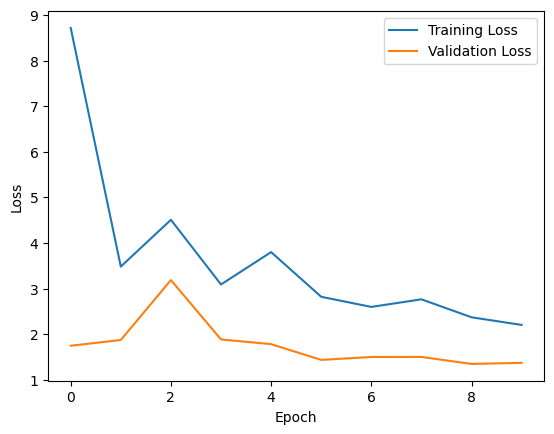

In [3]:
import matplotlib.pyplot as plt

def train_model(scheduler, model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels, weights in train_loader:
            images, labels, weights = torch.stack(images), torch.stack(labels), torch.stack(weights)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            weighted_loss = (loss * weights).sum()
            weighted_loss.backward()
            optimizer.step()
            running_loss += weighted_loss.item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}')
        
        # evaluate model
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels, weights in val_loader:
                images, labels, weights = torch.stack(images), torch.stack(labels), torch.stack(weights)
                outputs = model(images)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += (loss * weights).sum().item()

        scheduler.step()
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f'Validation Loss: {val_loss}')

    return train_losses, val_losses

model = SimpleCNN()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  # Learning rate scheduler

# training model
train_losses, val_losses = train_model(scheduler, model, criterion, optimizer, train_loader, val_loader, num_epochs=10)

# Plot training and validation loss
plt.figure()
plt.plot(range(10), train_losses, label='Training Loss')
plt.plot(range(10), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [6]:
from sklearn.metrics import mean_absolute_error, r2_score

# evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0.0
    val_labels = []
    val_predictions = []
    with torch.no_grad():
        for images, labels, weight in val_loader:
            images, labels = torch.stack(images), torch.stack(labels)
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            test_loss += loss.item() * images.size(0)
            val_labels.extend(labels.cpu().numpy())
            val_predictions.extend(outputs.squeeze().cpu().numpy())
    
    test_loss /= len(test_loader.dataset)
    mae = mean_absolute_error(val_labels, val_predictions)
    r2 = r2_score(val_labels, val_predictions)
    print(f'Test Loss: {test_loss}')
    print(f'Validation MAE: {mae}')
    print(f'Validation R²: {r2}')
    
    return test_loss, mae, r2, val_labels, val_predictions

tl, mae, r2, val_labels, val_predictions = evaluate_model(model, val_loader)



Test Loss: 1.912302017211914
Validation MAE: 1.133947730064392
Validation R²: 0.023316176527642618


In [ ]:
# # save the model
# torch.save(model.state_dict(), '/home/ubuntu/landscape-aesthetics/models/testing_model.pth')
# print("Model saved to testing_model.pth")

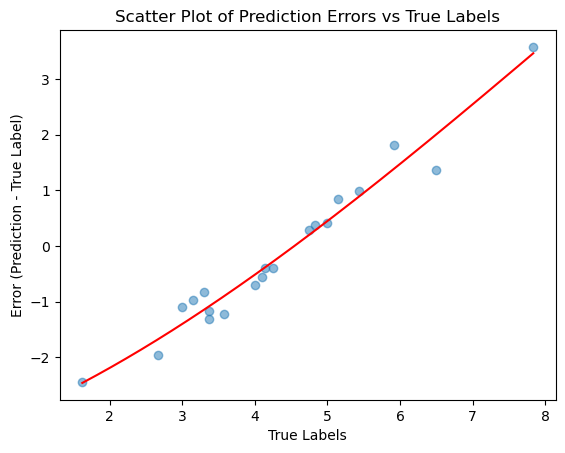

In [21]:
import numpy as np
errors = np.array(val_labels) - np.array(val_predictions)

plt.scatter(val_labels, errors, alpha=0.5)
plt.xlabel('True Labels')
plt.ylabel('Error (Prediction - True Label)')
plt.title('Scatter Plot of Prediction Errors vs True Labels')

degree_of_fit = 3 
z = np.polyfit(val_labels, errors, degree_of_fit)  
p = np.poly1d(z)  

x_range = np.linspace(min(val_labels), max(val_labels), 500)  
plt.plot(x_range, p(x_range), color='red', label=f'{degree_of_fit} degree fit')

plt.show()